In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

#import ipython_bell
import random
import sys
import pyfits
from astropy.io import fits
from astropy.table import Table

start_time = time.time()
plt.style.use('dark_background')

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/pyfits/__init__.py:22: PyFITSDeprecationWarning: PyFITS is deprecated, please use astropy.io.fits
  PyFITSDeprecationWarning)  # noqa


In [2]:
class ImageDataset(Dataset):
    """Dataset of Images and Labels"""

    def __init__(self, images, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.images[idx]
        label = np.array(self.labels[idx])
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [3]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
		
		# I like to add any scaling functions here, so uncomment if desired
		#image = (image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis]) / np.max(image - np.min(image, axis=(-1,-2))[:,:,np.newaxis,np.newaxis], axis=(-1,-2))[:,:,np.newaxis,np.newaxis]

        return {'image': torch.from_numpy(image).float(),
                'label': torch.from_numpy(label)}

In [4]:
def make_train_test_datasets(images, labels, test_size=0.2, transform=ToTensor()):
    """
	Make training and testing datasets
	
	Args:
	    images: 4D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images, train_labels, test_labels = train_test_split(
        images, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_labels, transform=transform),
            ImageDataset(test_images, test_labels, transform=transform))

In [5]:
class CNN(nn.Module):
    """
    Convolutional Neural Network for multiband data. Note that you
    will need to update the number of in_features for self.fc3.
    """
    def __init__(self, in_channels, num_classes):
        """
		Args:
		    in_channels: number of bands (gri = 3, griz=4)
			num_classes: number of unique labels in your dataset
		"""
        super(CNN, self).__init__()
        
        #Network Components
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                               out_channels=48, 
                               kernel_size=15, 
                               stride=3,
                               padding=2)

        self.conv2 = nn.Conv2d(in_channels=48, 
                               out_channels=96,
                               kernel_size=5, 
                               stride=1,
                               padding=2)
        
        self.dropout1 = nn.Dropout2d(0.25)
        
        self.dropout2 = nn.Dropout2d(0.5)
        
        self.fc1 = nn.Linear(in_features=3456, 
                             out_features=408)

        self.fc2 = nn.Linear(in_features=408, 
                             out_features=25)

        self.fc3 = nn.Linear(in_features=25, 
                             out_features=num_classes)


    def forward(self, x):
        #Network Flow
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        return output

    def init_weights(self, m):
        if (type(m) == nn.Linear or type(m) == nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

In [6]:
def train_cnn(
    cnn, 
    train_dataloader, 
    train_dataset=None,
    test_dataset=None,
    validation_size=None, 
    monitor=False,
    number_of_training_epochs=10,
    learning_rate=0.0001):
	
    """
    Train a CNN and output performance if desired

    Args:
        cnn: an instance of the CNN class
        train_dataloader: a PyTorch DataLoader for the training dataset
        train_dataset: an instance of the ImageDataset class for training
        test_dataset: an instance of the ImageDataset class for testing
        validation_size: the number of images to use for monitoring
            - large numbers will slow down training. ~100 is good.
        monitor: set to True if you want status updates on training
        number_of_training_epochs: number of times to go through the dataset
        learning_rate: multiplicative factor for updating network weights
            - small learning_rate will mean slow training
            - large learning_rate will train fast, but you may miss the best weights
            - ~0.001 is a good starting point
    """
    if not monitor and (train_dataset is None or test_dataset is None):
        raise ValueError("Must pass training and testing datasets for monitoring")
    
    if validation_size is None:
        validation_size=len(test_dataset)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
    
    losses, train_acc, validation_acc = [], [], []

    for epoch in range(number_of_training_epochs):
        sys.stdout.write("\rEpoch {0}\r".format(epoch + 1))
        sys.stdout.flush()

        for i_batch, sample_batched in enumerate(train_dataloader):

            #Clear out all existing gradients on the loss surface to reevaluate for this step
            optimizer.zero_grad()

            #Get the CNN's current prediction of the training data
            output = cnn(sample_batched['image'])

            #Calculate the loss by comparing the prediction to the truth
            loss = loss_function(output, sample_batched['label']) 

            #Evaluate all gradients along the loss surface using back propagation
            loss.backward()

            #Based on the gradients, take the optimal step in the weight space
            optimizer.step()

            #Performance monitoring if desired
            if monitor:
                if i_batch % 200 == 0: #before batch 200
                    train_output = cnn(train_dataset[0:validation_size]['image'])
                    validation_output = cnn(test_dataset[0:validation_size]['image'])

                    train_predictions = torch.max(train_output, 1)[1].data.numpy()
                    validation_predictions = torch.max(validation_output, 1)[1].data.numpy()

                    train_accuracy = np.sum(train_predictions == train_dataset[0:validation_size]['label'].numpy()) / validation_size
                    validation_accuracy = np.sum(validation_predictions == test_dataset[0:validation_size]['label'].numpy()) / validation_size

                    print("Epoch: {0} Batch: {1}  | Training Accuracy: {2:.3f} -- Validation Accuracy: {3:.3f} -- Loss: {4:.3f}".format(epoch + 1, i_batch + 1, train_accuracy, validation_accuracy, loss.data.numpy()))

                    losses.append(loss.data.numpy())
                    train_acc.append(train_accuracy)
                    validation_acc.append(validation_accuracy)
   
    setattr(cnn, 'losses', losses)
    setattr(cnn, 'train_acc', train_acc)
    setattr(cnn, 'validation_acc', validation_acc)

    return cnn

In [7]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues, name = 'generic'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(5,3), dpi=120)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set_xticks(np.arange(cm.shape[1]))
    ax.set_yticks(np.arange(cm.shape[0]))
    ax.set_xticklabels(classes, fontsize=12)
    ax.set_yticklabels(classes, fontsize=12)
    ax.set_xlabel('Predicted Class', fontsize=14)
    ax.set_ylabel('True Class', fontsize=14)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=12)
    fig.tight_layout()
    plt.show()
    return 

In [8]:
def plot_performance(cnn):
    x = np.linspace(1,len(cnn.losses),len(cnn.losses))
    fig, ax1 = plt.subplots(figsize=(12, 7), ncols=1)
    ax1.set_title('Performance')
    ax1.set_xlabel('Epoch')
    ax1.plot(x, cnn.losses, 'ko', label = 'Loss')
    ax1.plot(x, cnn.train_acc, 'ro', label = 'Training Accuracy')
    ax1.plot(x, cnn.validation_acc, 'go', label = 'Validation Accuracy')
    ax1.legend()
    plt.xlim([1.5, len(cnn.losses) + 0.5])
    plt.ylim([0, 2])
    plt.show(block=True)#'Performance_' + name +'.png', bbox_inches='tight')

In [9]:
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'

hdu_list = fits.open(path + 'other.fits')
idx = random.sample(range(len(hdu_list[1].data)), 350)
sim = hdu_list[1].data[idx,:] #[:1000]
data_sim = hdu_list[2].data[:][idx]
hdu_list.close()


In [10]:
test_neg = np.zeros((350, 4), dtype = np.float64)
names = ['z', 'm', 'b', 'E']
data_neg = Table(data = test_neg, names = names)
print(type(data_neg))
print(type(fits.BinTableHDU(data = data_neg)))
table_neg = fits.BinTableHDU(data = data_neg).data
print(type(table_neg))

<class 'astropy.table.table.Table'>
<class 'astropy.io.fits.hdu.table.BinTableHDU'>
<class 'astropy.io.fits.fitsrec.FITS_rec'>


In [11]:
print(data_sim.dtype)
data_sim = data_sim.astype([('z', '>f8'), ('m', '>f8'), ('b', '>f8'), ('E', '>f8')])
print(data_sim.dtype)

print( )

print(table_neg.dtype)
table_neg = table_neg.astype([('z', '>f8'), ('m', '>f8'), ('b', '>f8'), ('E', '>f8')])
print(table_neg.dtype)

(numpy.record, [('z', '>f8'), ('m', '>f8'), ('b', '>f8'), ('E', '>f8')])
[('z', '>f8'), ('m', '>f8'), ('b', '>f8'), ('E', '>f8')]

(numpy.record, [('z', '<f8'), ('m', '<f8'), ('b', '<f8'), ('E', '<f8')])
[('z', '>f8'), ('m', '>f8'), ('b', '>f8'), ('E', '>f8')]


In [12]:
#data_sim + table_neg
hdu3 = np.lib.recfunctions.stack_arrays([data_sim, table_neg], asrecarray=True, usemask=False)
print(type(hdu3))
print(hdu3.shape)
print(hdu3)


<class 'numpy.recarray'>
(700,)
[(0.5313528 , 23.25001677, 0.12772908, 0.86097171)
 (0.57758695, 23.25444008, 0.18225092, 0.68116623)
 (0.3531407 , 23.32600497, 0.37240707, 0.46398507)
 (0.46033219, 21.98736104, 0.91735053, 0.41294336)
 (0.5539521 , 22.82427538, 0.97501632, 0.63582405)
 (0.58814657, 22.85358119, 0.13705665, 0.56073323)
 (0.37171608, 24.4461755 , 0.01974878, 0.71017861)
 (0.6209142 , 22.65737933, 0.62317272, 0.79970074)
 (0.29165736, 22.81163581, 0.91543248, 0.34818753)
 (0.2248809 , 23.28293368, 0.2246738 , 0.99492903)
 (0.45988744, 22.27403551, 0.50777916, 1.22632529)
 (0.330139  , 23.08321365, 0.24312943, 0.77071987)
 (0.60834086, 24.35509256, 0.30648356, 0.31585495)
 (0.48645866, 24.75806381, 0.35162224, 0.4199608 )
 (0.657283  , 24.20044047, 0.34666367, 0.05531025)
 (0.5043709 , 24.57902259, 0.84517783, 0.45357974)
 (0.53085023, 23.17461025, 0.0833223 , 0.02442227)
 (0.4639341 , 23.54031924, 0.38757833, 0.40505028)
 (0.23046017, 21.70622815, 0.03967184, 1.59308964)

In [13]:
#### MAIN BODY CODE
torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

# load your images into an array called `images` with shape
#  (num_objects, num_bands, height, width)
path = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/Data/Sim_complete/'

hdu_list = fits.open(path + 'other.fits')
idx = random.sample(range(len(hdu_list[1].data)), 350)
sim = hdu_list[1].data[idx,:] #[:1000]
data_sim = hdu_list[2].data[:][idx]
hdu_list.close()


hdu_list = fits.open(path + 'negative_cases.fits')
idx = random.sample(range(len(hdu_list[1].data)), 350)
cutouts = hdu_list[1].data[idx,:] #[:1000]
hdu_list.close()

images = np.concatenate((sim, cutouts)).astype(np.float32)

# load your labels int0 an array called `labels` with shape
#  (num_objects,)
l1, l2 = np.zeros(len(sim), dtype = np.int64), np.ones(len(cutouts), dtype = np.int64)
labels = np.concatenate((l1, l2))
len_dataset = len(labels)

# Make train and test datasets
train_dataset, test_dataset = make_train_test_datasets(images, labels)

# Make a DataLoader to train the network
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True, num_workers=4) # batch_size = 20

# Make a CNN
cnn = CNN(
	in_channels=np.shape(images)[1], 
	num_classes=len(np.unique(labels)))

#Initialize weights
cnn.apply(cnn.init_weights)

CNN(
  (conv1): Conv2d(3, 48, kernel_size=(15, 15), stride=(3, 3), padding=(2, 2))
  (conv2): Conv2d(48, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=3456, out_features=408, bias=True)
  (fc2): Linear(in_features=408, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=2, bias=True)
)

In [14]:
# Train the CNN
cnn = train_cnn(cnn, 
				train_dataloader, 
				train_dataset=train_dataset,
				test_dataset=test_dataset,
				validation_size=200, #100
				number_of_training_epochs=200, #150
				monitor=True)

Epoch: 1 Batch: 1  | Training Accuracy: 0.530 -- Validation Accuracy: 0.340 -- Loss: 24.112
Epoch: 2 Batch: 1  | Training Accuracy: 0.565 -- Validation Accuracy: 0.315 -- Loss: 2.361
Epoch: 3 Batch: 1  | Training Accuracy: 0.515 -- Validation Accuracy: 0.310 -- Loss: 0.990
Epoch: 4 Batch: 1  | Training Accuracy: 0.470 -- Validation Accuracy: 0.385 -- Loss: 1.321
Epoch: 5 Batch: 1  | Training Accuracy: 0.565 -- Validation Accuracy: 0.350 -- Loss: 1.104
Epoch: 6 Batch: 1  | Training Accuracy: 0.515 -- Validation Accuracy: 0.345 -- Loss: 1.190
Epoch: 7 Batch: 1  | Training Accuracy: 0.480 -- Validation Accuracy: 0.325 -- Loss: 1.067
Epoch: 8 Batch: 1  | Training Accuracy: 0.530 -- Validation Accuracy: 0.365 -- Loss: 0.677
Epoch: 9 Batch: 1  | Training Accuracy: 0.545 -- Validation Accuracy: 0.380 -- Loss: 1.241
Epoch: 10 Batch: 1  | Training Accuracy: 0.515 -- Validation Accuracy: 0.335 -- Loss: 0.678
Epoch: 11 Batch: 1  | Training Accuracy: 0.500 -- Validation Accuracy: 0.365 -- Loss: 0.

Epoch: 91 Batch: 1  | Training Accuracy: 0.495 -- Validation Accuracy: 0.360 -- Loss: 0.670
Epoch: 92 Batch: 1  | Training Accuracy: 0.490 -- Validation Accuracy: 0.335 -- Loss: 0.731
Epoch: 93 Batch: 1  | Training Accuracy: 0.535 -- Validation Accuracy: 0.340 -- Loss: 0.730
Epoch: 94 Batch: 1  | Training Accuracy: 0.485 -- Validation Accuracy: 0.345 -- Loss: 0.695
Epoch: 95 Batch: 1  | Training Accuracy: 0.480 -- Validation Accuracy: 0.335 -- Loss: 0.711
Epoch: 96 Batch: 1  | Training Accuracy: 0.465 -- Validation Accuracy: 0.350 -- Loss: 0.702
Epoch: 97 Batch: 1  | Training Accuracy: 0.495 -- Validation Accuracy: 0.375 -- Loss: 0.683
Epoch: 98 Batch: 1  | Training Accuracy: 0.490 -- Validation Accuracy: 0.345 -- Loss: 0.707
Epoch: 99 Batch: 1  | Training Accuracy: 0.465 -- Validation Accuracy: 0.365 -- Loss: 0.680
Epoch: 100 Batch: 1  | Training Accuracy: 0.470 -- Validation Accuracy: 0.370 -- Loss: 0.735
Epoch: 101 Batch: 1  | Training Accuracy: 0.470 -- Validation Accuracy: 0.325 -

Epoch: 180 Batch: 1  | Training Accuracy: 0.555 -- Validation Accuracy: 0.355 -- Loss: 0.674
Epoch: 181 Batch: 1  | Training Accuracy: 0.515 -- Validation Accuracy: 0.395 -- Loss: 0.636
Epoch: 182 Batch: 1  | Training Accuracy: 0.495 -- Validation Accuracy: 0.390 -- Loss: 0.681
Epoch: 183 Batch: 1  | Training Accuracy: 0.600 -- Validation Accuracy: 0.350 -- Loss: 0.650
Epoch: 184 Batch: 1  | Training Accuracy: 0.545 -- Validation Accuracy: 0.390 -- Loss: 0.841
Epoch: 185 Batch: 1  | Training Accuracy: 0.475 -- Validation Accuracy: 0.350 -- Loss: 0.672
Epoch: 186 Batch: 1  | Training Accuracy: 0.520 -- Validation Accuracy: 0.380 -- Loss: 0.634
Epoch: 187 Batch: 1  | Training Accuracy: 0.490 -- Validation Accuracy: 0.335 -- Loss: 0.669
Epoch: 188 Batch: 1  | Training Accuracy: 0.505 -- Validation Accuracy: 0.390 -- Loss: 0.695
Epoch: 189 Batch: 1  | Training Accuracy: 0.535 -- Validation Accuracy: 0.335 -- Loss: 0.699
Epoch: 190 Batch: 1  | Training Accuracy: 0.470 -- Validation Accuracy

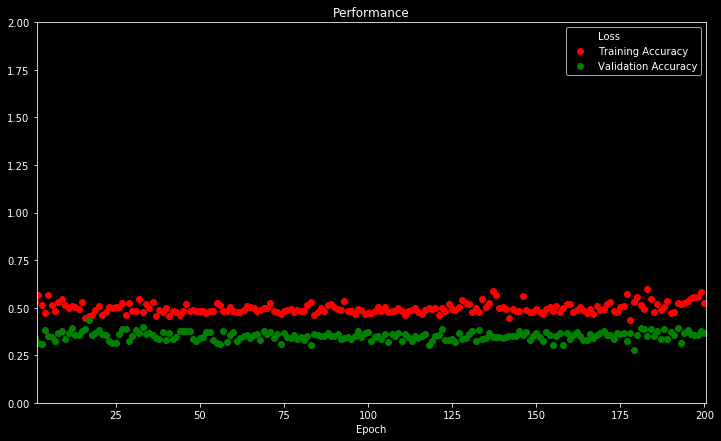

In [15]:
#plot learning rate
plot_performance(cnn)

In [16]:
# Use the CNN to classify your whole test dataset
cnn.eval()

non_binary_predictions = cnn(test_dataset[:]['image'])

test_predictions = torch.max(cnn(test_dataset[:]['image']), 1)[1].data.numpy()  
test_labels = test_dataset[:]['label'].data.numpy()

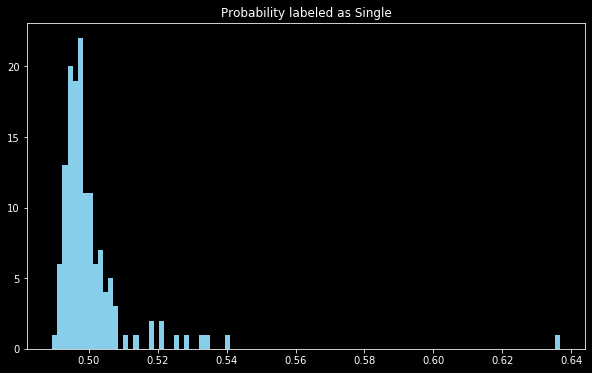

In [17]:
m = nn.Softmax(dim=1) 
prob = (m(non_binary_predictions))
prob = prob[:,0].detach().numpy()

plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob, 100, color = "skyblue")
plt.show()

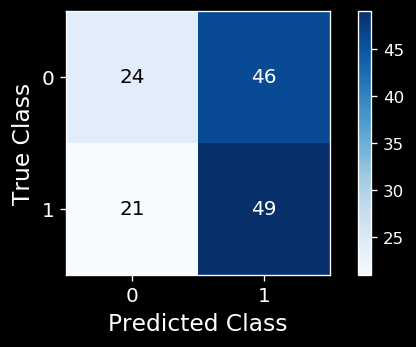

In [18]:
# Plot a confusion matrix of your results
classes = np.unique(labels)
plot_confusion_matrix(test_labels, test_predictions, classes)